# Train

```$ python keras_retinanet/bin/train.py --batch-size 1 --epochs 100 --steps 50 csv dataset/deepfashion/instances_train2017.csv dataset/deepfashion/categories2017.csv```

In [7]:
import sys
sys.path.append("..")

%run keras_retinanet/bin/train.py --batch-size 1 --epochs 100 --steps 50 csv dataset/deepfashion/instances_train2017.csv ../dataset/deepfashion/categories2017.csv

ValueError: attempted relative import beyond top-level package

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.csv_generator import CSVGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf



def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
model = keras.models.load_model('/Users/luke/Documents/ml_models/weight_resnet50_csv_epoch_02_loss_1.88947_regression_loss_1.47016_classification_loss_0.41931.h5', custom_objects=custom_objects)

/Users/luke/.pyenv/versions/3.6.3/envs/py36/lib/python3.6/site-packages/keras/models.py:274: UserWarning: Output "nms" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "nms" during training.
  sample_weight_mode=sample_weight_mode)


In [10]:
# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

# create a generator for testing data
val_generator = CSVGenerator(
    "../dataset/deepfashion/instances_val2017.csv",
    "../dataset/deepfashion/categories2017.csv",
    batch_size=1,
)
index = 0

processing time:  7.599647045135498
Tee
Jeans


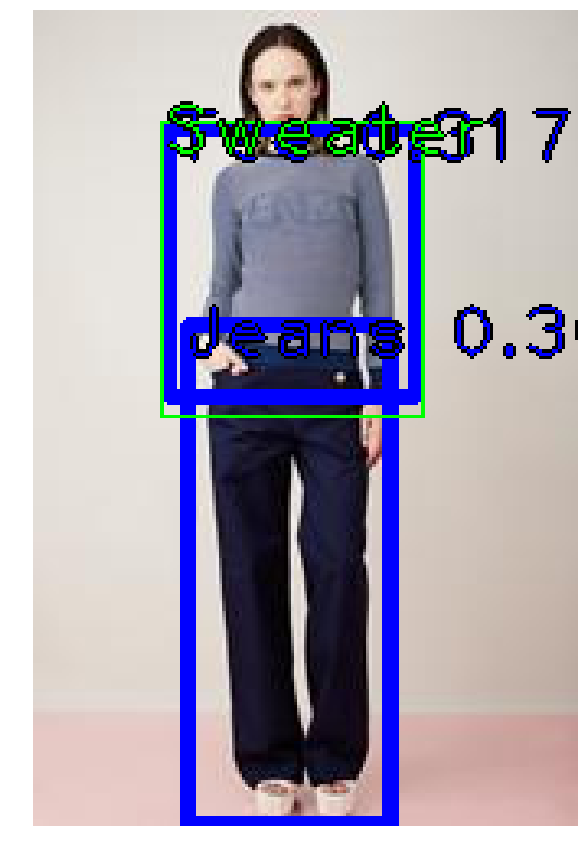

In [23]:
# load image
image = val_generator.load_image(index)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = val_generator.preprocess_image(image)
image, scale = val_generator.resize_image(image)
annotations = val_generator.load_annotations(index)
index += 1

# process image
start = time.time()
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels] 

# correct for image scale
detections[0, :, :4] /= scale

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.3:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
    caption = "{} {:.3f}".format(val_generator.label_to_name(label), score)
    print(val_generator.label_to_name(label))
    cv2.putText(draw, caption, (b[0], b[1] + 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 2)
    cv2.putText(draw, caption, (b[0], b[1] + 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 255), 1)
    
# visualize annotations
for annotation in annotations:
    label = int(annotation[4])
    b = annotation[:4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 1)
    caption = "{}".format(val_generator.label_to_name(label))
    cv2.putText(draw, caption, (b[0], b[1] + 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 2)
    cv2.putText(draw, caption, (b[0], b[1] + 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 1)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()